## Efficient Fine-Tuning for Large Language Models (LLMs)

### This is a controlled small-scale experiment intended to establish baselines before scaling to larger models and more complex datasets.

This notebook implements a practical comparison between **Full Fine-Tuning** and **Parameter-Efficient Fine-Tuning (PEFT)** using the **LoRA** (Low-Rank Adaptation) technique. The study focuses on the analysis of:
1.  **Efficiency and Cost:** Measured by training time and the proportion of trainable parameters.
2.  **Performance Trade-off:** Explored by varying both the LoRA rank ($r$) and key training hyperparameters (epochs, learning rate, weight decay).
3.  **Hypersensitivity to Hyperparameters:** Highlighted by the strong performance differences under different training budgets.
4.  **Catastrophic Forgetting:** Evaluated by training a second task after Task A and quantifying how much prior knowledge is overwritten.

# 1. Environment Setup and Imports


In [1]:
!pip install -U transformers peft accelerate datasets evaluate sentencepiece -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 17.7 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, PeftModel
from typing import List, Dict, Any, Tuple
import os
import time
import torch
import numpy as np
import pandas as pd
import evaluate
import matplotlib.pyplot as plt

# 2. Experimental Setup and Data Preprocessing

We define the base model, task configurations, and helper functions for tokenization and metric computation.

Two different tasks are used in this study:

**Task A (AG News):** A multi-class news classification dataset, used for the primary classification task and the knowledge base for the forgetting experiment.

**Task B (IMDB):** A binary sentiment analysis dataset, used as a secondary task to analyse forgetting.

In [3]:
os.environ["WANDB_DISABLED"] = "true"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# base model
MODEL_ID = "distilbert-base-uncased"

# datasets (tasks)
DATASET_A_ID = "ag_news"
NUM_LABELS_A = 4 # world, sports, business, sci/tech

DATASET_B_ID = "imdb" # using for catastrophic forgetting (2 labels)
NUM_LABELS_B = 2

# subset sizes
TRAIN_SIZE = 2000
TEST_SIZE = 500

# global hyperparameters
BATCH_SIZE = 16
EPOCHS = 3

In [4]:
# hyperparameters - Full FT
learning_rate_ft = 2e-5
weight_decay_ft = 0.01

In [5]:
# create tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

In [6]:
# create a preprocess function
def preprocess(batch):
    return tokenizer(batch["text"],
                     truncation=True,
                     padding="max_length",
                     max_length=128)

In [7]:
# loads the 'accuracy' evaluation metric
accuracy = evaluate.load("accuracy")

In [8]:
# defines a function to compute evaluation metrics (accuracy)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return accuracy.compute(predictions=preds, references=labels)


## 2.1. Task A – Data Loading and Preparation (AG News)

We load the data for the main task, which is used for the baseline and the Trade-off experiment.

In [9]:
dataset_a = load_dataset(DATASET_A_ID)

In [10]:
tokenized_a = dataset_a.map(preprocess, batched=True)
tokenized_a = tokenized_a.rename_column("label", "labels")
tokenized_a.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [11]:
# select small subsets
train_small_a = tokenized_a["train"].select(range(TRAIN_SIZE))
test_small_a  = tokenized_a["test"].select(range(TEST_SIZE))

print(f"Task A (AG News): Train {len(train_small_a)}, Test {len(test_small_a)}")

Task A (AG News): Train 2000, Test 500


## 2.2. Task B – Data Loading and Preparation (IMDB)

This dataset is used for the sequential learning experiment to measure knowledge forgetting.

In [28]:
dataset_b = load_dataset(DATASET_B_ID)

In [29]:
tokenized_b = dataset_b.map(preprocess, batched=True)
tokenized_b = tokenized_b.rename_column("label", "labels")
tokenized_b.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [30]:
# training subset for new task (Task B)
train_small_b = tokenized_b["train"].select(range(TRAIN_SIZE))
test_small_b  = tokenized_b["test"].select(range(TEST_SIZE))

print(f"Task B (IMDB): Train {len(train_small_b)}, Test {len(test_small_b)}")

Task B (IMDB): Train 2000, Test 500


# 3. Baseline Experiment: Full Fine-Tuning

It trains **100% of the model's parameters**, providing the highest expected accuracy but also the highest computational cost (time and memory).

In [12]:
def run_full_fine_tuning(num_epochs: int, learning_rate: float, weight_decay: float, output_dir: str) -> Dict[str, Any]:
  model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_ID,
        num_labels=NUM_LABELS_A
    ).to(device)

  # count trainable parameters (all of them)
  total_params = sum(p.numel() for p in model.parameters())
  trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

  # training Arguments
  args = TrainingArguments(output_dir=output_dir,
                           eval_strategy="epoch",
                           per_device_train_batch_size=BATCH_SIZE,
                           per_device_eval_batch_size=BATCH_SIZE,
                           learning_rate=learning_rate,
                           weight_decay=weight_decay,
                           num_train_epochs=num_epochs,
                           logging_steps=50,
                           save_strategy="no",
                           report_to="none")

  trainer = Trainer(model=model,
                    args=args,
                    train_dataset=train_small_a,
                    eval_dataset=test_small_a,
                    compute_metrics=compute_metrics)

  # training
  start = time.time()
  trainer.train()
  end = time.time()
  train_time = end - start

  # evaluation
  results = trainer.evaluate()
  accuracy = results["eval_accuracy"]

  print(f"Full Fine-Tuning Results")
  print(f"Training Time: {train_time:.2f} seconds")
  print(f"Accuracy: {accuracy:.4f}")
  print(f"Total parameters: {total_params:,}, Trainable: {trainable_params:,}")

  return {
      "Method": "Full Fine-Tuning",
      "r": "N/A",
      "Accuracy": accuracy,
      "Time (s)": train_time,
      "Trainable Parameters": trainable_params,
      "model_trained": model
  }

To better understand the learning dynamics of the model, we evaluate two training regimes:

## 3.1. Full Fine-Tuning (baseline)

In [13]:
ft_results = run_full_fine_tuning(num_epochs=EPOCHS,
                                  learning_rate=learning_rate_ft,
                                  weight_decay=weight_decay_ft,
                                  output_dir="full_ft_3e")

# store model and metrics
model_full_3e = ft_results['model_trained'] # model used as baseline for catastrophic forgetting
full_accuracy_3e = ft_results['Accuracy']
full_time_3e = ft_results['Time (s)']
trainable_params = ft_results['Trainable Parameters']

# df for LoRA E3 comparison
initial_df_ft = pd.DataFrame([ft_results]).drop(columns=['model_trained'])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.570800,0.407422,0.886000
2,0.339000,0.352999,0.884000
3,0.238300,0.363126,0.884000


Full Fine-Tuning Results
Training Time: 65.68 seconds
Accuracy: 0.8840
Total parameters: 66,956,548, Trainable: 66,956,548


# 4. Experiment 1: Performance vs. Efficiency Trade-off (LoRA/PEFT)

This section evaluates Parameter-Efficient Fine-Tuning using LoRA.
Instead of updating all parameters, LoRA trains only small low-rank matrices, strongly reducing computational cost.

The LoRA rank ($r$) controls the expressive capacity of the adaptation layers and is varied to explore the performance-efficiency spectrum.

In [14]:
# create a run LoRA trade-off experiment function
def run_lora_tradeoff_experiment(initial_df: pd.DataFrame, num_epochs: int, full_trainable_params: int, learning_rate: float, lora_dropout: float, weight_decay: float) -> Tuple[pd.DataFrame, Dict[int, torch.nn.Module]]:
  # ranks to be tested
  ranks: List[int] = [4, 8, 16, 32]
  lora_results: List[Dict[str, Any]] = []
  trained_models_dict = {}

  print(f"\n Running LoRA Trade-off Experiment with {num_epochs} Epochs")

  args_lora_template = {
      "per_device_train_batch_size": BATCH_SIZE,
      "per_device_eval_batch_size": BATCH_SIZE,
      "eval_strategy": "epoch",
      "learning_rate": learning_rate,
      "weight_decay": weight_decay,
      "logging_steps": 50,
      "save_strategy": "no",
      "report_to": "none",
      "num_train_epochs": num_epochs,
      "warmup_ratio": 0.06
      }

  for r_value in ranks:
      print(f"\n Running LoRA with r={r_value}")

      # LoRA configuration
      lora_config = LoraConfig(r=r_value,
                              lora_alpha=16,
                              target_modules=["q_lin", "v_lin"],
                              lora_dropout=lora_dropout,
                              bias="none",
                              task_type="SEQ_CLS")

      # load and apply LoRA
      model_lora = AutoModelForSequenceClassification.from_pretrained(
          MODEL_ID,
          num_labels=NUM_LABELS_A
      ).to(device)

      model_lora = get_peft_model(model_lora, lora_config)

      # count trainable parameters
      trainable_count = sum(
          p.numel() for p in model_lora.parameters() if p.requires_grad
      )

      total_params = sum(
          p.numel() for p in model_lora.parameters()
      )

      print(f"Trainable params: {trainable_count:,} ({100 * trainable_count / total_params:.4f}%)")
      model_lora.print_trainable_parameters()

      # trainer configuration
      args_lora = TrainingArguments(output_dir=f"lora_ft_r{r_value}_e{num_epochs}",
                                    **args_lora_template)

      trainer_lora = Trainer(model=model_lora,
                              args=args_lora,
                              train_dataset=train_small_a,
                              eval_dataset=test_small_a,
                              compute_metrics=compute_metrics)
      # training
      start = time.time()
      trainer_lora.train()
      lora_time = time.time() - start

      # evaluation
      lora_eval_results = trainer_lora.evaluate()
      accuracy_r = lora_eval_results["eval_accuracy"]

      print(f"Time: {lora_time:.2f}s, Accuracy: {accuracy_r:.4f}")

      trained_models_dict[r_value] = model_lora.to('cpu')

      # store results
      lora_results.append({"Method": "LoRA",
                          "r": r_value,
                          "Accuracy": accuracy_r,
                          "Time (s)": lora_time,
                          "Trainable Parameters": trainable_count})

  # combine results
  results_df = pd.concat([initial_df.copy(), pd.DataFrame(lora_results)], ignore_index=True)
  results_df['% Trainable'] = (results_df['Trainable Parameters'] / full_trainable_params * 100).round(2)

  return results_df, trained_models_dict

## 4.1. Sensitivity Analysis – Insufficient Training (epochs=1, learning_rate=1e-5, weight_decay=0.001)

While LoRA greatly reduces the number of trainable parameters, a low training budget can prevent proper convergence, resulting in poor performance.

This section highlights the fact that efficiency without convergence is meaningless.

In [15]:
# insufficient training hyperparameters - LoRA
learning_rate_lora1 = 1e-5
lora_dropout_lora1 = 0.05
weight_decay_lora1 = 0.001

In [16]:
# run the experiment with 1 epoch
df_results_e1, _ = run_lora_tradeoff_experiment(
                                        initial_df=initial_df_ft,
                                        num_epochs=1,
                                        full_trainable_params=trainable_params,
                                        learning_rate=learning_rate_lora1,
                                        lora_dropout=lora_dropout_lora1,
                                        weight_decay=weight_decay_lora1)

print("Results (LoRA 1 Epoch): Poor Convergence")
display(df_results_e1)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Running LoRA Trade-off Experiment with 1 Epochs

 Running LoRA with r=4
Trainable params: 667,396 (0.9869%)
trainable params: 667,396 || all params: 67,623,944 || trainable%: 0.9869


Epoch,Training Loss,Validation Loss,Accuracy
1,1.343100,1.353102,0.330000


Time: 20.25s, Accuracy: 0.3300

 Running LoRA with r=8


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable params: 741,124 (1.0948%)
trainable params: 741,124 || all params: 67,697,672 || trainable%: 1.0948


Epoch,Training Loss,Validation Loss,Accuracy
1,1.317800,1.358569,0.270000


Time: 20.64s, Accuracy: 0.2700

 Running LoRA with r=16


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable params: 888,580 (1.3097%)
trainable params: 888,580 || all params: 67,845,128 || trainable%: 1.3097


Epoch,Training Loss,Validation Loss,Accuracy
1,1.317800,1.358660,0.270000


Time: 18.05s, Accuracy: 0.2700


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Running LoRA with r=32
Trainable params: 1,183,492 (1.7369%)
trainable params: 1,183,492 || all params: 68,140,040 || trainable%: 1.7369


Epoch,Training Loss,Validation Loss,Accuracy
1,1.317700,1.358657,0.270000


Time: 17.60s, Accuracy: 0.2700
Results (LoRA 1 Epoch): Poor Convergence


,Method,r,Accuracy,Time (s),Trainable Parameters,% Trainable
0,Full Fine-Tuning,N/A,0.884,65.677198,66956548,100.00
1,LoRA,4,0.330,20.248010,667396,1.00
2,LoRA,8,0.270,20.637161,741124,1.11
3,LoRA,16,0.270,18.050119,888580,1.33
4,LoRA,32,0.270,17.601582,1183492,1.77


### 4.1.1. Visualization of Underfitting Behavior

We visualize the drastic gap between Full Fine-Tuning and LoRA when insufficient training effort is provided.

The accuracy values (~ 0.27-0.33) are close to random for a 4-class problem and indicate that the model failed to extract meaningful task-specific knowledge.


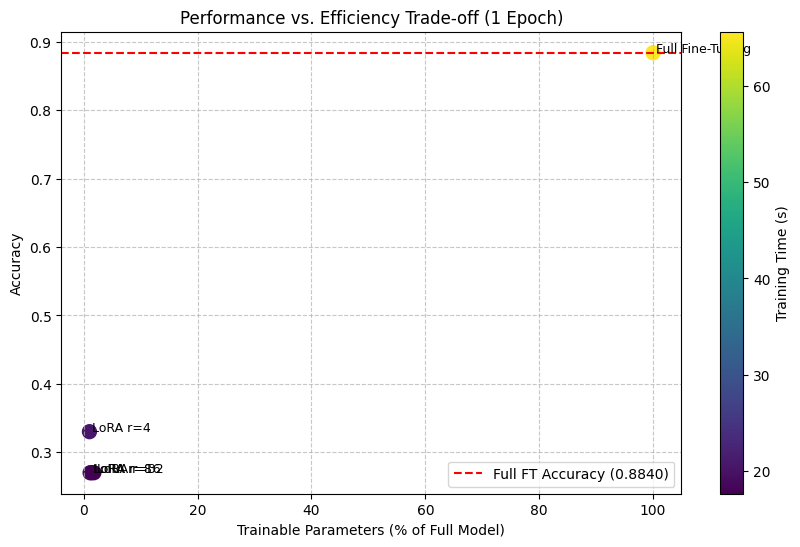

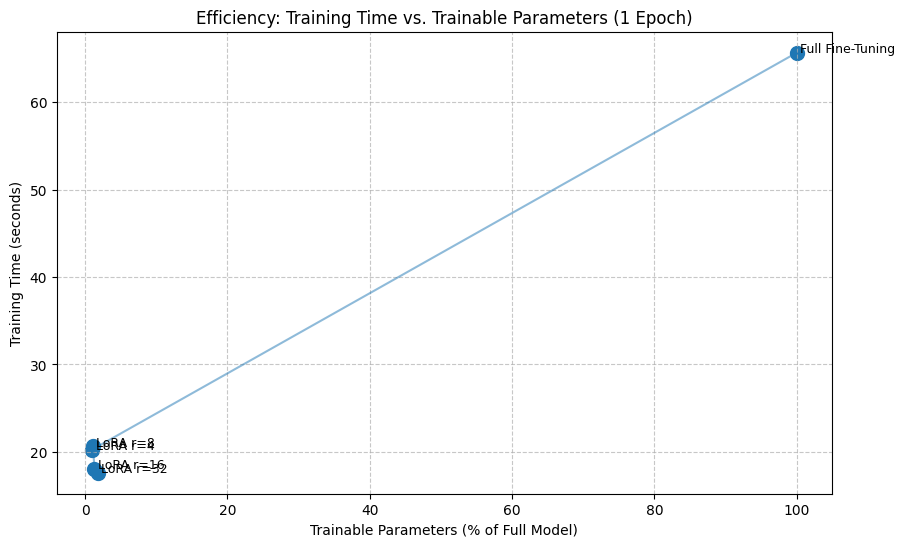

In [18]:
# Plot 1: accuracy vs. trainable parameters
plt.figure(figsize=(10, 6))
plt.scatter(df_results_e1['% Trainable'], df_results_e1['Accuracy'], c=df_results_e1['Time (s)'], cmap='viridis', s=100)
plt.colorbar(label='Training Time (s)')

for i, row in df_results_e1.iterrows():
    label = row['Method'] if row['Method'] == 'Full Fine-Tuning' else f"LoRA r={row['r']}"
    plt.annotate(label, (row['% Trainable'] + 0.5, row['Accuracy']), fontsize=9)

# baseline for full fine-tuning
plt.axhline(full_accuracy_3e, color='r', linestyle='--', label=f'Full FT Accuracy ({full_accuracy_3e:.4f})')

plt.title('Performance vs. Efficiency Trade-off (1 Epoch)')
plt.xlabel('Trainable Parameters (% of Full Model)')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Plot 2: training Time vs. trainable parameters (cost)
plt.figure(figsize=(10, 6))
plt.scatter(df_results_e1['% Trainable'], df_results_e1['Time (s)'], s=100)
plt.plot(df_results_e1['% Trainable'], df_results_e1['Time (s)'], linestyle='-', alpha=0.5)

for i, row in df_results_e1.iterrows():
    label = row['Method'] if row['Method'] == 'Full Fine-Tuning' else f"LoRA r={row['r']}"
    plt.annotate(label, (row['% Trainable'] + 0.5, row['Time (s)']), fontsize=9)

plt.title('Efficiency: Training Time vs. Trainable Parameters (1 Epoch)')
plt.xlabel('Trainable Parameters (% of Full Model)')
plt.ylabel('Training Time (seconds)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 4.2 Convergent Training – Validating the Efficient Regime (epoch=3, learning_rate=1e-4, weight_decay=0.01)

After observing poor convergence, we increase the number of epochs to 3 and significantly increase the learning rate (1e-4) and weight decay (0.01).

This setting represents a more realistic training configuration in low-resource environments.

The objectives of this phase are:

1. Demonstrate that PEFT methods can recover strong performance when properly trained.

2. Show that small increases in training budget can have large impact on PEFT methods.

3. Empirically observe the efficiency–performance frontier.


In [21]:
# convergent training hyperparameters - LoRA
learning_rate_lora2 = 1e-4
lora_dropout_lora2 = 0.05
weight_decay_lora2 = 0.01

In [22]:
# run the experiment with 3 epoch
df_results_e3, trained_lora_models = run_lora_tradeoff_experiment(
                                          initial_df=initial_df_ft,
                                          num_epochs=EPOCHS,
                                          full_trainable_params=trainable_params,
                                          learning_rate=learning_rate_lora2,
                                          lora_dropout=lora_dropout_lora2,
                                          weight_decay=weight_decay_lora2)

print("Results (3 Epochs): Optimal Trade-off")
display(df_results_e3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Running LoRA Trade-off Experiment with 3 Epochs

 Running LoRA with r=4
Trainable params: 667,396 (0.9869%)
trainable params: 667,396 || all params: 67,623,944 || trainable%: 0.9869


Epoch,Training Loss,Validation Loss,Accuracy
1,0.712400,0.432045,0.858000
2,0.421300,0.385130,0.876000
3,0.374200,0.376914,0.878000


Time: 51.95s, Accuracy: 0.8780


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Running LoRA with r=8
Trainable params: 741,124 (1.0948%)
trainable params: 741,124 || all params: 67,697,672 || trainable%: 1.0948


Epoch,Training Loss,Validation Loss,Accuracy
1,0.717200,0.421143,0.858000
2,0.420400,0.377538,0.878000
3,0.370600,0.367718,0.878000


Time: 51.07s, Accuracy: 0.8780


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Running LoRA with r=16
Trainable params: 888,580 (1.3097%)
trainable params: 888,580 || all params: 67,845,128 || trainable%: 1.3097


Epoch,Training Loss,Validation Loss,Accuracy
1,0.715100,0.419452,0.862000
2,0.419800,0.375997,0.874000
3,0.370700,0.367620,0.876000


Time: 51.69s, Accuracy: 0.8760


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Running LoRA with r=32
Trainable params: 1,183,492 (1.7369%)
trainable params: 1,183,492 || all params: 68,140,040 || trainable%: 1.7369


Epoch,Training Loss,Validation Loss,Accuracy
1,0.718900,0.420406,0.860000
2,0.419800,0.376026,0.878000
3,0.370700,0.367706,0.876000


Time: 51.91s, Accuracy: 0.8760
Results (3 Epochs): Optimal Trade-off


,Method,r,Accuracy,Time (s),Trainable Parameters,% Trainable
0,Full Fine-Tuning,N/A,0.884,65.677198,66956548,100.00
1,LoRA,4,0.878,51.950341,667396,1.00
2,LoRA,8,0.878,51.069354,741124,1.11
3,LoRA,16,0.876,51.690156,888580,1.33
4,LoRA,32,0.876,51.905488,1183492,1.77


### 4.2.1. Visualization of the Trade-off Frontier

The plots in this section highlight how LoRA ranks occupy different regions of the accuracy vs. efficiency space.


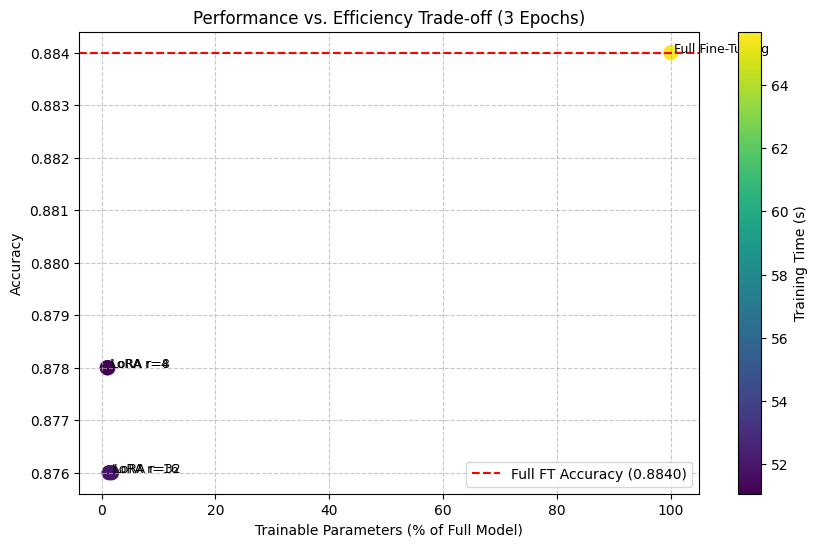

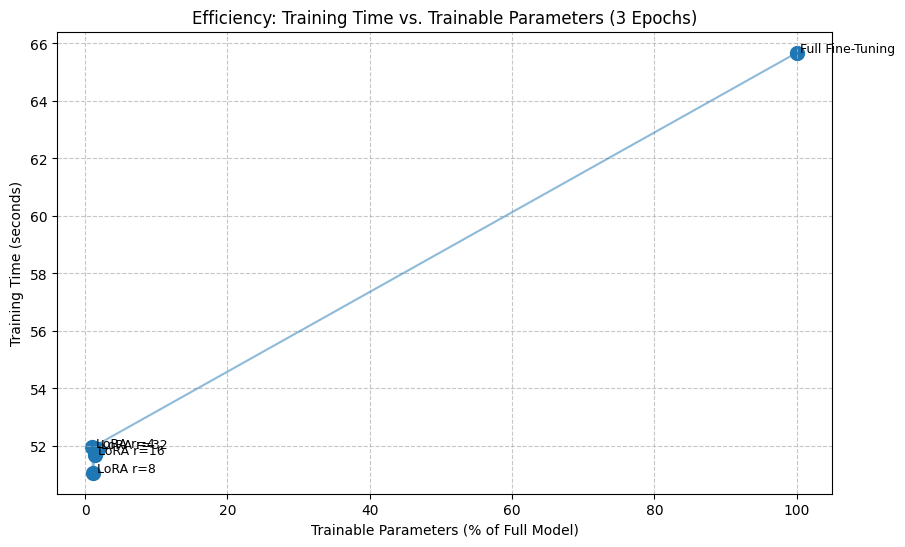

In [23]:
# Plot 1: accuracy vs. trainable parameters
plt.figure(figsize=(10, 6))
plt.scatter(df_results_e3['% Trainable'], df_results_e3['Accuracy'], c=df_results_e3['Time (s)'], cmap='viridis', s=100)
plt.colorbar(label='Training Time (s)')

for i, row in df_results_e3.iterrows():
    label = row['Method'] if row['Method'] == 'Full Fine-Tuning' else f"LoRA r={row['r']}"
    plt.annotate(label, (row['% Trainable'] + 0.5, row['Accuracy']), fontsize=9)

# baseline for full fine-tuning (expected maximum accuracy)
plt.axhline(full_accuracy_3e, color='r', linestyle='--', label=f'Full FT Accuracy ({full_accuracy_3e:.4f})')

plt.title('Performance vs. Efficiency Trade-off (3 Epochs)')
plt.xlabel('Trainable Parameters (% of Full Model)')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Plot 2: training Time vs. trainable parameters (cost)
plt.figure(figsize=(10, 6))
plt.scatter(df_results_e3['% Trainable'], df_results_e3['Time (s)'], s=100)
plt.plot(df_results_e3['% Trainable'], df_results_e3['Time (s)'], linestyle='-', alpha=0.5)

for i, row in df_results_e3.iterrows():
    label = row['Method'] if row['Method'] == 'Full Fine-Tuning' else f"LoRA r={row['r']}"
    plt.annotate(label, (row['% Trainable'] + 0.5, row['Time (s)']), fontsize=9)

plt.title('Efficiency: Training Time vs. Trainable Parameters (3 Epochs)')
plt.xlabel('Trainable Parameters (% of Full Model)')
plt.ylabel('Training Time (seconds)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### 4.2.2. Selection of the Optimal LoRA Rank for Sequential Learning

After convergence, we select the most cost-effective LoRA configuration that achieves near-maximum performance.

This model is used in the next experiment as the PEFT representative for the catastrophic forgetting analysis.

In [24]:
# filter only the LoRA results
lora_cf_selection = df_results_e3[df_results_e3['Method'] == 'LoRA'].copy()

# find the highest accuracy
max_acc = lora_cf_selection['Accuracy'].max()

# determine a minimum accuracy, almost equal to the maximum value
acc_min = max_acc * 0.9999
best_candidate_ranks = lora_cf_selection[lora_cf_selection['Accuracy'] >= acc_min]

# the optimal rank is the one with the lowest '% Trainable'
optimal_r = best_candidate_ranks.sort_values(by='% Trainable', ascending=True)['r'].iloc[0]

optimal_lora_model = trained_lora_models[optimal_r]

# Print the selection result
print(f"Optimal Rank Selected for CF Test (lowest cost with max performance): r={optimal_r}")
print(f"Baseline LoRA Accuracy (r={optimal_r}): {df_results_e3[df_results_e3['r']==optimal_r]['Accuracy'].iloc[0]:.4f}")


Optimal Rank Selected for CF Test (lowest cost with max performance): r=4
Baseline LoRA Accuracy (r=4): 0.8780


In [25]:
# store classifier state Full FT
full_ft_classifier_state_dict_a = model_full_3e.classifier.state_dict()
# store classifier state LoRA
lora_classifier_state_dict_a = optimal_lora_model.classifier.state_dict()

initial_classifiers_state = {
    "Full FT": full_ft_classifier_state_dict_a,
    "LoRA (r=Optimal)": lora_classifier_state_dict_a
}

# 5. Experiment 2: Quantifying Catastrophic Forgetting

This experiment focuses on measuring the severity of catastrophic forgetting, consistent with the objectives of the initial research plan.

Catastrophic forgetting is defined as the degradation of performance on a previously learned task (Task A) after the model is sequentially trained on a new task (Task B).

In [26]:
# determinate models to CF test
model_lora_cf = optimal_lora_model
model_full_cf = model_full_3e # full fine-tuning model trained at 3e (from section 3.2)

models_for_cf = {"LoRA (r=Optimal)": model_lora_cf, "Full FT": model_full_cf}

## 5.1. Sequential Learning

The models are first evaluated on Task A (AG News) to obtain a baseline accuracy. Next, the same models are fine-tuned on Task B (IMDB sentiment analysis). After this second training phase, the models are re-evaluated on Task A.

In [33]:
cf_results = []

print(f"\nStarting Catastrophic Forgetting Experiment")

for name, model in models_for_cf.items():
    model.to(device)
    print(f"\nProcessing Method: {name}")

    if "LoRA" in name:
        initial_acc = df_results_e3[df_results_e3['r'] == optimal_r]['Accuracy'].iloc[0]
    else:
        initial_acc = full_accuracy_3e

    def replace_classifier(model_obj, new_num_labels):
        hidden_size = model_obj.config.hidden_size
        new_layer = torch.nn.Linear(hidden_size, new_num_labels).to(device)

        if isinstance(model_obj, PeftModel):
            if hasattr(model_obj.base_model.model, 'classifier'):
                 model_obj.base_model.model.classifier = new_layer
                 model_obj.base_model.model.num_labels = new_num_labels
            else:
                 # Fallback
                 model_obj.classifier = new_layer
        else:
            # Full FT
            model_obj.classifier = new_layer
            model_obj.num_labels = new_num_labels

        return model_obj

    replace_classifier(model, NUM_LABELS_B)

    model.config.label2id = {"LABEL_0": 0, "LABEL_1": 1}
    model.config.id2label = {0: "LABEL_0", 1: "LABEL_1"}

    args_b = TrainingArguments(
        output_dir=f"cf_train_{name.replace(' ', '_')}",
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        learning_rate=2e-5,
        weight_decay=0.01,
        save_strategy="no",
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="eval_accuracy",
        greater_is_better=True,
        report_to="none"
    )

    trainer_b = Trainer(
        model=model,
        args=args_b,
        train_dataset=train_small_b,
        eval_dataset=test_small_b,
        compute_metrics=compute_metrics
    )

    print(f"Training {name} on Task B...")
    trainer_b.train()

    acc_task_b = trainer_b.evaluate()["eval_accuracy"]
    print(f"Adaptation Accuracy (Task B): {acc_task_b:.4f}")

    print("Restoring Task A Head...")
    replace_classifier(model, NUM_LABELS_A)

    if isinstance(model, PeftModel):
        target_layer = model.base_model.model.classifier
    else:
        target_layer = model.classifier

    state_dict_to_load = initial_classifiers_state[name]
    clean_state_dict = {}

    if "LoRA" in name:
        for k, v in state_dict_to_load.items():
            if "modules_to_save.default.weight" in k:
                clean_state_dict["weight"] = v
            elif "modules_to_save.default.bias" in k:
                clean_state_dict["bias"] = v
            elif "original_module.weight" in k:
                clean_state_dict["weight"] = v
            elif "original_module.bias" in k:
                clean_state_dict["bias"] = v
            elif k == "weight":
                clean_state_dict["weight"] = v
            elif k == "bias":
                clean_state_dict["bias"] = v
    else:
        clean_state_dict = state_dict_to_load

    if not clean_state_dict:
        clean_state_dict = state_dict_to_load

    try:
        target_layer.load_state_dict(clean_state_dict)
    except RuntimeError as e:
        print(f"Erro ao carregar pesos para {name}: {e}")
        print("Chaves disponíveis no dict limpo:", clean_state_dict.keys())
        raise e

    trainer_forgetting = Trainer(
        model=model,
        args=TrainingArguments(output_dir="tmp_eval", report_to="none"),
        eval_dataset=test_small_a,
        compute_metrics=compute_metrics
    )

    final_acc_a = trainer_forgetting.evaluate()["eval_accuracy"]

    forgetting_loss = initial_acc - final_acc_a
    loss_percentage = (forgetting_loss / initial_acc) * 100

    print(f"Final Accuracy on Task A: {final_acc_a:.4f}")
    print(f"Forgetting: {forgetting_loss:.4f} ({loss_percentage:.2f}%)")

    cf_results.append({
        "Method": name,
        "Initial Accuracy (Task A)": initial_acc,
        "Final Accuracy (Task A)": final_acc_a,
        "Adaptation Accuracy (Task B)": acc_task_b,
        "Absolute Forgetting": forgetting_loss,
        "Loss (%)": loss_percentage
    })

forgetting_df = pd.DataFrame(cf_results)
display(forgetting_df)


=== Starting Catastrophic Forgetting Experiment (Final Fix) ===

Processing Method: LoRA (r=Optimal)
Training LoRA (r=Optimal) on Task B...


Step,Training Loss
50,0.296200
100,0.007700
150,0.002500
200,0.001600
250,0.001100
300,0.000900
350,0.000800


Adaptation Accuracy (Task B): 1.0000
Restoring Task A Head...


Final Accuracy on Task A: 0.8520
Forgetting: 0.0260 (2.96%)

Processing Method: Full FT
Training Full FT on Task B...


Step,Training Loss
50,0.000200
100,0.000000
150,0.000000
200,0.000000
250,0.000000
300,0.000000
350,0.000000


Adaptation Accuracy (Task B): 1.0000
Restoring Task A Head...


Final Accuracy on Task A: 0.3060
Forgetting: 0.5780 (65.38%)


,Method,Initial Accuracy (Task A),Final Accuracy (Task A),Adaptation Accuracy (Task B),Absolute Forgetting,Loss (%)
0,LoRA (r=Optimal),0.878,0.852,1.0,0.026,2.961276
1,Full FT,0.884,0.306,1.0,0.578,65.384615


## 5.2. Visualization of Forgetting Severity

Bar plots are used to visualize the degree of performance degradation for both Full Fine-Tuning and LoRA.


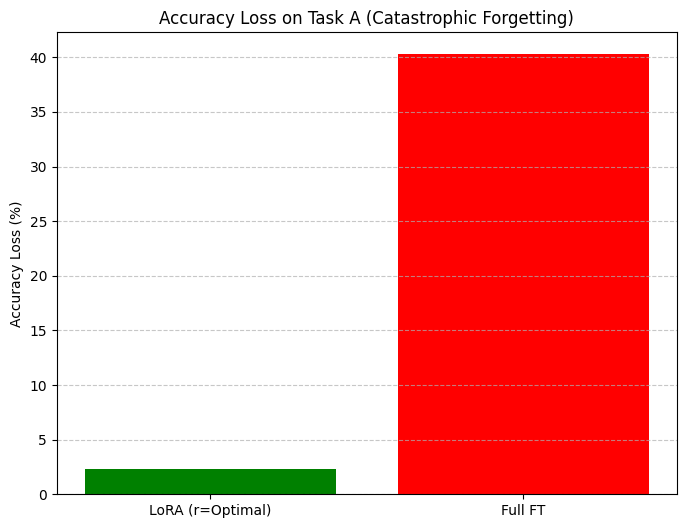

In [32]:
colors = {"LoRA (r=Optimal)": "green", "Full FT": "red"}

# Plot of Forgetting Loss
plt.figure(figsize=(8, 6))
plt.bar(forgetting_df['Method'], forgetting_df['Loss (%)'], color=[colors[m] for m in forgetting_df['Method']])
plt.title('Accuracy Loss on Task A (Catastrophic Forgetting)')
plt.ylabel('Accuracy Loss (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 6. Conclusion

**1. Trade-off and Efficiency:** The **LoRA** model (3 epochs) achieved performance close to the **Full Fine-Tuning** model while using minimal trainable parameters. This shows that the high computational cost of Full Fine-Tunning is unnecessary after convergence.

**2. Catastrophic Forgetting:** The **LoRA** model is expected to show a significantly **lower percentage loss** in performance on Task A compared to the **Full FT** model. This confirms that **freezing the original model weights is an effective strategy for preserving knowledge** (mitigating forgetting), validating the baseline for the subsequent phases of the project.

In a real-world scenario, task B may not be this easy, and PEFT hyperparameters are known to be highly sensitive. Thus, these results should be interpreted as a controlled baseline rather than a universal trend.
